# Análisis 2da Encuesta de inserción de científicos en Chile

**Autor:** Roberto Muñoz <br />
**E-mail:** <rmunoz@metricarts.com> <br />
**Github:** <https://github.com/rpmunoz> <br />

Análisis preliminar de la [2da Encuesta de inserción de científicos](https://anip.cl/wp-content/uploads/2018/07/Informe-encuesta-insercion-laboral-ANIP-2018.pdf) llevada a cabo por el Centro de estudios de la ANIP. 

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
from scipy import stats, integrate

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from IPython.core.display import display, HTML

%matplotlib inline
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'axes.titlepad': 16,
         'axes.titlesize': 20,
         'axes.labelpad': 16,
         'axes.labelsize': 16,
         'lines.linewidth': 3,
         'lines.markersize': 8,
         'xtick.labelsize': 12,
         'ytick.labelsize': 12}
plt.rcParams.update(params)

sns.despine()
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 100)

<Figure size 576x432 with 0 Axes>

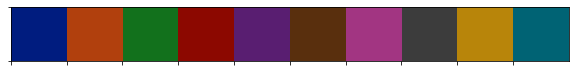

In [4]:
current_palette = sns.color_palette('dark')
sns.palplot(current_palette)

In [ ]:
def autopct_generator(limit):
    def inner_autopct(pct):
        return ('%.1f%%' % pct) if pct > limit else ''
    return inner_autopct

## 1. Cargamos el nuevo archivo de datos

Revisaremos los valores de algunos campos

In [5]:
encuesta_clean_file="data/E2018-full-answers-clean.csv"

encuesta_full_df=pd.read_csv(encuesta_clean_file)
encuesta_full_df.head()

,ID de la respuesta,Fecha en que inició,Fecha de la ultima accion,¿Cuál es el grado académico más alto que has obtenido?,¿En qué disciplina y área clasificarías tu pregrado?,¿En qué disciplina y área clasificarías tu pregrado? [Otro],¿En qué año obtuviste tu pregrado?,¿En qué disciplina y área clasificarías tu {postgrado}?,¿En qué disciplina y área clasificarías tu {postgrado}? [Otro],¿En qué año obtuviste tu {postgrado}?,¿En qué lugar realizaste tu {postgrado}?,"En total, ¿cuántos artículos revisados por pares (peer-reviewed) has publicado en los últimos 5 años?","¿Cómo financiaste tus estudios de {postgrado}? [Fondos personales (e.g., ahorros, aporte familiar, etc.)]","¿Cómo financiaste tus estudios de {postgrado}? [Trabajo durante el estudio (e.g., pasantías, ayudantías, etc.)]","¿Cómo financiaste tus estudios de {postgrado}? [Fondos no personales nacionales (e.g., becas Conicyt, Becas Chile, premios, etc.)]","¿Cómo financiaste tus estudios de {postgrado}? [Fondos no personales extranjeros (e.g., becas o premios de universidad de estudios)]",¿Qué tipo de trabajo desempeñaste para financiar tus estudios? [Ayudantía(s) en mi área de estudio],¿Qué tipo de trabajo desempeñaste para financiar tus estudios? [Ayudantía(s) en otra área de estudio],¿Qué tipo de trabajo desempeñaste para financiar tus estudios? [Pasantía(s) en otros lugares de estudio o centros de investigación],"¿Qué tipo de trabajo desempeñaste para financiar tus estudios? [Trabajo en mi lugar de estudio, sin relación con mis estudios]",¿Qué tipo de trabajo desempeñaste para financiar tus estudios? [Trabajo fuera de mi lugar de estudio],¿Qué tipo de trabajo desempeñaste para financiar tus estudios? [Trabajo remoto de cualquier tipo],¿Qué tipo de trabajo desempeñaste para financiar tus estudios? [Otro],¿Con qué tipo de fondos nacionales financiaste tu {postgrado}? [Beca o premio (por favor indica el nombre de la beca o premio)],¿Con qué tipo de fondos nacionales financiaste tu {postgrado}? [Comentario],¿Con qué tipo de fondos nacionales financiaste tu {postgrado}? [Crédito de un banco (por favor indica el nombre del banco)],¿Con qué tipo de fondos nacionales financiaste tu {postgrado}? [Comentario].1,¿Con qué tipo de fondos nacionales financiaste tu {postgrado}? [Financiamiento de empleador (por favor indica el nombre del empleador)],¿Con qué tipo de fondos nacionales financiaste tu {postgrado}? [Comentario].2,¿Con qué tipo de fondos nacionales financiaste tu {postgrado}? [Otro tipo de fondos (por favor indica qué tipo)],¿Con qué tipo de fondos nacionales financiaste tu {postgrado}? [Comentario].3,¿Con qué tipo de fondos extranjeros financiaste tu {postgrado}? [Beca o premio (por favor indica el nombre de la beca o premio)],¿Con qué tipo de fondos extranjeros financiaste tu {postgrado}? [Comentario],¿Con qué tipo de fondos extranjeros financiaste tu {postgrado}? [Crédito de un banco (por favor indica el nombre del banco)],¿Con qué tipo de fondos extranjeros financiaste tu {postgrado}? [Comentario].1,¿Con qué tipo de fondos extranjeros financiaste tu {postgrado}? [Financiamiento de empleador (por favor indica el nombre del empleador)],¿Con qué tipo de fondos extranjeros financiaste tu {postgrado}? [Comentario].2,¿Con qué tipo de fondos extranjeros financiaste tu {postgrado}? [Otro tipo de fondos (por favor indica qué tipo)],¿Con qué tipo de fondos extranjeros financiaste tu {postgrado}? [Comentario].3,¿Estás realizando o has realizado algún postdoctorado?,¿En qué disciplina y área clasificarías tu postdoctorado?,¿En qué disciplina y área clasificarías tu postdoctorado? [Otro],"¿En qué año terminaste tu postdoctorado? Si actuamente estás haciendo un postdoctorado, por favor responde ""Estoy haciendo un postdoctorado ahora"".",¿En qué lugar realizaste (o estás realizando) tu postdoctorado?,¿Has terminado más de un postdoctorado?,¿Cuántos postdoctorados has realizado?,¿Estás en Chile ahora?,¿Tuviste que renunciar a algún trabajo u oportunidad académica por volver a Chil

In [ ]:
len(encuesta_full_df)

In [ ]:
encuesta_full_df.dtypes.to_frame().transpose()

## 2. Análisis exploratorio

In [ ]:
field_names_full=['¿Cuál es el grado académico más alto que has obtenido?',
                  '¿En qué año obtuviste tu pregrado?',
                  '¿En qué disciplina y área clasificarías tu pregrado?',
                  '¿En qué año obtuviste tu {postgrado}?',
                  '¿En qué disciplina y área clasificarías tu {postgrado}?',
                  '¿En qué lugar realizaste tu {postgrado}?',
                  '¿Estás realizando o has realizado algún postdoctorado?',
                  '¿En qué año terminaste tu postdoctorado? Si actuamente estás haciendo un postdoctorado, por favor responde "Estoy haciendo un postdoctorado ahora".',
                  '¿En qué disciplina y área clasificarías tu postdoctorado?',
                  '¿En qué lugar realizaste (o estás realizando) tu postdoctorado?',
                  'En total, ¿cuántos artículos revisados por pares (peer-reviewed) has publicado en los últimos 5 años?',
                  '¿Estás en Chile ahora?',
                  'Actualmente, ¿tienes trabajo remunerado en Chile?',
                  'Actualmente, ¿estás buscando trabajo?',
                  '¿Crees que seguirás desempeñando este trabajo remunerado en julio de 2018?',
                  '¿En qué institución o área realizas tu trabajo?',
                  '¿A qué sector económico pertenece este trabajo?',
                  '¿Qué tipo de relación laboral tienes en este trabajo?',
                  'Respecto de tu trabajo, ¿qué tan satisfecho estás con...? [Tu estabilidad laboral]',
                  'Respecto de tu trabajo, ¿qué tan satisfecho estás con...? [El reto intelectual que supone el trabajo]',
                  '¿En qué región de Chile realizas este trabajo?',
                  '¿Cuál es tu género?',
                  '¿Cuál es tu edad?',
                  '¿Cuál es tu nacionalidad? En caso de tener más de una nacionalidad, por favor escoge tu país de origen (donde naciste).',
                  'Finalmente, ¿cuál es tu opinión sobre el sistema de ciencia y tecnología en Chile, y sobre el proceso de inserción de científicos en Chile?',
                  '¿Has sufrido algún tipo de discriminación en tu(s) trabajo(s) como científico o científica? [No he sufrido discriminación]',
                  '¿Has sufrido algún tipo de discriminación en tu(s) trabajo(s) como científico o científica? [Sí, discriminación de género]',
                  '¿Has sufrido algún tipo de discriminación en tu(s) trabajo(s) como científico o científica? [Sí, discriminación por ser extranjero/a]',
                  '¿Has sufrido algún tipo de discriminación en tu(s) trabajo(s) como científico o científica? [Sí, discriminación por tener discapacidad]',
                  '¿Has sufrido algún tipo de discriminación en tu(s) trabajo(s) como científico o científica? [Sí, discriminación por tener hijos o hijas]',
                  '¿Has sufrido algún tipo de discriminación en tu(s) trabajo(s) como científico o científica? [Sí, discriminación por estar sobrecalificado]',
                  '¿Has sufrido algún tipo de discriminación en tu(s) trabajo(s) como científico o científica? [Otro]']

field_names=['Grado académico',
             'Año obtención pregrado',
             'Area pregrado',
             'Año obtención postgrado',
             'Area postgrado',
             'País postgrado',
             'Postdoctorado',
             "Año postdoctorado",
             'Area postdoctorado',
             'País postdoctorado',
             'Número de papers',
             'Estas en Chile',
             'Tiene trabajo remunerado',
             'Buscando trabajo',
             'Permanencia trabajo',
             'Sector empleo',
             'Sector económico',
             'Tipo de contrato',
             'Estabilidad laboral',
             'Reto intelectual',
             'Region trabajo',
             'Genero',
             'Edad',
             'Nacionalidad',
             'Opinión sistema CTI',
             'No he sufrido discriminación',
             'Discriminación de género',
             'Discriminación por ser extranjero/a',
             'Discriminación por tener discapacidad',
             'Discriminación por tener hijos/as',
             'Discriminación por estar sobrecalificado',
             'Discriminación otro']

encuesta_df=encuesta_full_df[field_names_full].copy()
encuesta_df.columns=field_names

encuesta_df.head()

Seleccionamos solo a las personas con grado académico de Doctorado

In [ ]:
encuesta_df=encuesta_df[encuesta_df['Grado académico']=='Doctorado (PhD)']
len(encuesta_df)

In [ ]:
for field_name in field_names:
    if field_name != "Opinión sistema CTI":
        print("Field: ", field_name)
        print(encuesta_df[field_name].unique())

Revisamos categorias del campo año de obtención de pregrado y postgrado

In [ ]:
encuesta_df.loc[encuesta_df['Año obtención pregrado']=='Antes de 1990','Año obtención pregrado']=1990
encuesta_df.loc[encuesta_df['Año obtención postgrado']=='Antes de 1990','Año obtención postgrado']=1990

Revisamos los casos en que la persona reporta que obtuvo el postgrado dos años despues del pregrado

In [ ]:
encuesta_df['Año obtención pregrado'] = encuesta_df['Año obtención pregrado'].astype(int)
encuesta_df['Año obtención postgrado'] = encuesta_df['Año obtención postgrado'].astype(int)

pregrado_incorrecto = (encuesta_df['Año obtención postgrado']-encuesta_df['Año obtención pregrado']) < 3
print("Numero de pregrado incorrecto: ", len(encuesta_df[pregrado_incorrecto]))
encuesta_df.loc[pregrado_incorrecto,'Año obtención pregrado'] = 0

In [ ]:
encuesta_df['Año obtención pregrado'].unique()

In [ ]:
encuesta_df['Año postdoctorado'].unique()

### Revisamos categorias del campo situación laboral

In [ ]:
encuesta_df['Situacion laboral']=np.NaN
encuesta_df.loc[encuesta_df['Tiene trabajo remunerado']=='Sí','Situacion laboral']='Ocupado'
encuesta_df.loc[encuesta_df['Tiene trabajo remunerado']=='No','Situacion laboral']='Desempleado'
encuesta_df.loc[(encuesta_df['Tiene trabajo remunerado']=='No') & (encuesta_df['Buscando trabajo']=='No'),'Situacion laboral']='Inactivo'

In [ ]:
encuesta_df.groupby('Situacion laboral').size()

### Revisamos la discriminación en el empleo

In [ ]:
encuesta_df['Discriminación']=np.NaN
encuesta_df.loc[encuesta_df['No he sufrido discriminación']=='Sí','Discriminación']='No'

encuesta_df.loc[encuesta_df['Discriminación de género']=='Sí','Discriminación']='Sí'
encuesta_df.loc[encuesta_df['Discriminación por ser extranjero/a']=='Sí','Discriminación']='Sí'
encuesta_df.loc[encuesta_df['Discriminación por tener discapacidad']=='Sí','Discriminación']='Sí'
encuesta_df.loc[encuesta_df['Discriminación por tener hijos/as']=='Sí','Discriminación']='Sí'
encuesta_df.loc[encuesta_df['Discriminación por estar sobrecalificado']=='Sí','Discriminación']='Sí'
encuesta_df.loc[encuesta_df['Discriminación otro'].isnull() == False,'Discriminación']='Sí'

In [ ]:
encuesta_df.groupby('Discriminación').size()

## Análisis de Postdoctorado

In [ ]:
encuesta_df['País postdoctorado'].unique()

In [ ]:
encuesta_df['Año postdoctorado'].unique()

In [ ]:
encuesta_df.groupby('Postdoctorado').size()

In [ ]:
encuesta_df.groupby(['Postdoctorado',"Genero"]).size()

In [ ]:
#encuesta_df.groupby(['Postdoctorado','Año obtención postgrado','Año postdoctorado']).size()
encuesta_df.groupby(['Postdoctorado','Año obtención postgrado']).size()

In [ ]:
encuesta_df.groupby(['Postdoctorado','Año obtención postgrado'])['Número de papers'].median()

In [ ]:
encuesta_df.groupby(['Postdoctorado','Area postdoctorado']).size()#.sort_values()

In [ ]:
encuesta_df.groupby(['Situacion laboral','Postdoctorado']).size()

In [ ]:
pd.DataFrame(encuesta_df[encuesta_df['Año postdoctorado']=='Estoy haciendo un postdoctorado ahora'].groupby(['Situacion laboral','Postdoctorado']).size())

In [ ]:
pd.DataFrame(encuesta_df[encuesta_df['Año postdoctorado']=='Estoy haciendo un postdoctorado ahora'].groupby(['Situacion laboral','Postdoctorado','País postdoctorado']).size())

Algunas personas indicaron estar haciendo un postdoctorado ahora, por lo cual están ocupados

In [ ]:
encuesta_df.loc[encuesta_df['Año postdoctorado']=='Estoy haciendo un postdoctorado ahora','Situacion laboral']='Ocupado'

In [ ]:
encuesta_df.groupby('Situacion laboral').size()

Revisamos categorias del campo estabilidad laboral

In [ ]:
encuesta_df.loc[encuesta_df['Estabilidad laboral']=='1 (Muy insatisfecho)','Estabilidad laboral']='1'
encuesta_df.loc[encuesta_df['Estabilidad laboral']=='4 (Ni satisfecho ni insatisfecho)','Estabilidad laboral']='4'
encuesta_df.loc[encuesta_df['Estabilidad laboral']=='7 (Muy satisfecho)','Estabilidad laboral']='7'

Revisamos categorias del campo Reto intelectual

In [ ]:
encuesta_df.loc[encuesta_df['Reto intelectual']=='1 (Muy insatisfecho)','Reto intelectual']='1'
encuesta_df.loc[encuesta_df['Reto intelectual']=='4 (Ni satisfecho ni insatisfecho)','Reto intelectual']='4'
encuesta_df.loc[encuesta_df['Reto intelectual']=='7 (Muy satisfecho)','Reto intelectual']='7'

Acortamos el nombre de la categoría 'A honorarios ("Boletear sin contrato"

In [ ]:
encuesta_df.loc[encuesta_df['Tipo de contrato']=='A honorarios ("Boletear sin contrato")','Tipo de contrato']="Boletear sin contrato"
encuesta_df['Tipo de contrato'].unique()

### Corregir campo "Estas en Chile" para personas que obtuvieron postgrado o postdoc en Chile

In [ ]:
encuesta_df.loc[encuesta_df["Estas en Chile"].isnull(), "Estas en Chile"]="Postgrado en Chile"

Agregamos la categoria inactivo al campo 'Tiene trabajo remunerado'. Es útil para identificar a personas que responden No en 'Buscando trabajo'

In [ ]:
field_dtypes={'Grado académico':'category',
              'Año obtención pregrado':int,
              'Año obtención postgrado':int,
              'Tiene trabajo remunerado':'category',
              'Buscando trabajo':'category',
              'Situacion laboral':'category',
              'Tipo de contrato':'category',
              'Permanencia trabajo':'category',
              'Sector empleo':'category',
              'Estabilidad laboral':'category',
              'Reto intelectual':'category',
              'Region trabajo':'category',
              'Genero':'category',
              'Edad':float,
              'Nacionalidad':'category'}

for name, dtype in field_dtypes.items():
    encuesta_df[name] = encuesta_df[name].astype(dtype)
    
encuesta_df['Situacion laboral']=pd.Categorical(encuesta_df['Situacion laboral'], ["Ocupado", "Desempleado", "Inactivo"], ordered=True)
encuesta_df['Permanencia trabajo']=pd.Categorical(encuesta_df['Permanencia trabajo'], ["Sí", "No", "No estoy seguro(a)"], ordered=True)

In [ ]:
len(encuesta_df)

# 2.1 Análisis demográfico

In [ ]:
encuesta_df.groupby('Genero').size()

In [ ]:
age_bins=[0, 34, 44, 54, 64, 69]
age_labels=['< 35 años', '35-44 años', '45-54 años', '55-64 años', '65-69 años']
encuesta_df['Grupo etario']=pd.cut(encuesta_df['Edad'], age_bins, labels=age_labels)

data_plot=encuesta_df.groupby('Genero')['Grupo etario'].value_counts().unstack('Genero')
data_plot=data_plot.reindex(age_labels)
data_plot

In [ ]:
data_plot.sum().sum()

In [ ]:
data_plot_pct=(100*data_plot/data_plot.sum().sum()).round(1)
data_plot_pct

In [ ]:
data_plot_pct.sum(axis=0)

In [ ]:
data_plot_pct.sum(axis=1)

In [ ]:
plot_classes=["Masculino","Femenino"]

fig, ax = plt.subplots(1,1, figsize=(12,6))
data_plot_pct[plot_classes].plot(kind='bar', ax=ax,
               fontsize=12, rot=0, width=0.8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(frameon=False)

ax.set_ylim(0,40)
ax.set_xlabel('Edad')
plt.title("Distribución de grupos etarios\nProfesionales con grado de Doctorado")

vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])

for p in ax.patches:
    ax.annotate("{:.1f}%".format(p.get_height()), (p.get_x() + 0.2, p.get_height() + 1),
               fontsize=12, horizontalalignment='center')

plt.savefig('figures/doctorado/figura_1_distribucion_grupo_etario.png', bbox_inches='tight')
plt.savefig('figures/doctorado/figura_1_distribucion_grupo_etario.pdf', bbox_inches='tight')

## 4.2 Año obtención de pregrado

In [ ]:
data_plot=pd.DataFrame(encuesta_df.groupby('Año obtención pregrado').size(), columns=['Número de egresados'])
data_plot=data_plot[data_plot.index > 0]
data_plot.head()

In [ ]:
data_plot.sum()

In [ ]:
data_plot['Percentage']=(100*data_plot/data_plot.sum().sum()).round(2)
data_plot

In [ ]:
data_plot['CumSum']=data_plot['Percentage'].cumsum()
data_plot

In [ ]:
data_plot['CumSum']

In [ ]:
print(data_plot.loc[2007:,'Percentage'].sum())
print(data_plot.loc[2007:,"Número de egresados"].sum())

print("Total de doctores que reportan año pregrado: ", data_plot["Número de egresados"].sum())

In [ ]:
encuesta_df[encuesta_df['Año obtención pregrado']>0]['Año obtención pregrado'].median()

In [ ]:
quartile_bins=[0, 25, 50, 75, 101]
quartile_labels=['q1', 'q2', 'q3', 'q4']
data_plot['Quartile']=pd.cut(data_plot['CumSum'], quartile_bins, labels=quartile_labels)
data_plot.head()

In [ ]:
colors = {'q1':current_palette[0],'q2':current_palette[1],'q3':current_palette[2],'q4':current_palette[3]}
data_plot['color'] = data_plot['Quartile'].map(colors)
data_plot.head()

In [ ]:
plot_field="Número de egresados"

fig, ax = plt.subplots(1,1, figsize=(8,12))
data_plot[plot_field].plot(kind='barh', ax=ax,
               fontsize=12, rot=0, width=0.8, color=data_plot['color'])

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim(0,90)
ax.set_xlabel('Número de egresados')
plt.title("Año de obtención del pregrado\nProfesionales con grado de Doctorado")

for p in ax.patches:
    ax.annotate("{:d}".format(p.get_width()), (p.get_width() + 2, p.get_y()+0.3),
               fontsize=14, horizontalalignment='left', verticalalignment='center')
   
plt.savefig('figures/doctorado/figura_2_año_obtencion_pregrado.png', bbox_inches='tight')
plt.savefig('figures/doctorado/figura_2_año_obtencion_pregrado.pdf', bbox_inches='tight')

In [ ]:
#encuesta_df.style.set_properties(subset=['Opinión sistema CTI'], **{'width': '300px'})
#encuesta_df[encuesta_df['Año obtención pregrado']==2017]

In [ ]:
#encuesta_df[(encuesta_df['Año obtención postgrado']-encuesta_df['Año obtención pregrado']) < 3]

## 4.2 Año obtención de postgrado

In [ ]:
data_plot=pd.DataFrame(encuesta_df.groupby('Año obtención postgrado').size(), columns=['Número de egresados'])
data_plot.head()

In [ ]:
data_plot['Percentage']=(100*data_plot/data_plot.sum().sum()).round(2)
data_plot.head()

In [ ]:
data_plot['CumSum']=data_plot['Percentage'].cumsum()
data_plot.head()

In [ ]:
quartile_bins=[0, 25, 50, 75, 101]
quartile_labels=['q1', 'q2', 'q3', 'q4']
data_plot['Quartile']=pd.cut(data_plot['CumSum'], quartile_bins, labels=quartile_labels)
data_plot.head()

In [ ]:
colors = {'q1':current_palette[0],'q2':current_palette[1],'q3':current_palette[2],'q4':current_palette[3]}
data_plot['color'] = data_plot['Quartile'].map(colors)
data_plot.head()

In [ ]:
plot_field="Número de egresados"

fig, ax = plt.subplots(1,1, figsize=(8,12))
data_plot[plot_field].plot(kind='barh', ax=ax,
               fontsize=12, rot=0, width=0.8, color=data_plot['color'])

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim(0,100)
ax.set_xlabel('Número de egresados')
plt.title("Año de obtención del Doctorado")

for p in ax.patches:
    ax.annotate("{:d}".format(p.get_width()), (p.get_width() + 2, p.get_y()+0.3),
               fontsize=14, horizontalalignment='left', verticalalignment='center')

plt.savefig('figures/doctorado/figura_3_año_obtencion_postgrado.png', bbox_inches='tight')
plt.savefig('figures/doctorado/figura_3_año_obtencion_postgrado.pdf', bbox_inches='tight')

## 4.3 Situación laboral

In [ ]:
data_plot=encuesta_df.groupby('Genero')['Situacion laboral'].value_counts().unstack('Genero')
data_plot=data_plot.reindex(['Ocupado','Desempleado','Inactivo'])
data_plot

In [ ]:
data_plot.sum().sum()

In [ ]:
data_plot_pct=(100*data_plot/data_plot.sum()).round(1)
data_plot_pct.head()

In [ ]:
plot_classes=["Masculino","Femenino"]

fig, ax = plt.subplots(1,1, figsize=(12,6))
data_plot_pct[plot_classes].plot(kind='bar', ax=ax,
               fontsize=12, rot=0, width=0.8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(frameon=False)

ax.set_ylim(0,100)
ax.set_xlabel('Situación laboral')
plt.title("Situación laboral por género\nProfesionales con grado de Doctor")

vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])

for p in ax.patches:
    ax.annotate("{:.1f}%".format(p.get_height()), (p.get_x() + 0.2, p.get_height() + 4),
               fontsize=12, horizontalalignment='center')

plt.savefig('figures/doctorado/figura_4_situacion_laboral_genero.png', bbox_inches='tight')
plt.savefig('figures/doctorado/figura_4_situacion_laboral_genero.pdf', bbox_inches='tight')

In [ ]:
data_plot=encuesta_df[(encuesta_df['Situacion laboral']=="Desempleado") & (encuesta_df['Genero']=="Femenino")]
data_plot
pd.DataFrame(data_plot.groupby(["País postgrado","Estas en Chile","Area postgrado","Postdoctorado"]).size())
pd.DataFrame(data_plot.groupby(["País postgrado","Postdoctorado"]).size(), columns=["Nº desocupados"])

In [ ]:
pd.DataFrame(encuesta_df.groupby(["Situacion laboral","Area postgrado"]).size()).sort_values(["Situacion laboral",0], ascending=False)
encuesta_df[encuesta_df["Area postgrado"]=="Ciencias Naturales:Ciencias Biológicas"].groupby(["Situacion laboral","Area postgrado"]).size()

## Repetimos análisis pero sin separar por género

In [ ]:
data_plot=encuesta_df.groupby('Situacion laboral').size()
data_plot=data_plot.reindex(['Ocupado','Desempleado','Inactivo'])
data_plot

In [ ]:
data_plot_pct=(100*data_plot/data_plot.sum()).round(1)
data_plot_pct.head()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
data_plot_pct.plot(kind='bar', ax=ax,
               fontsize=12, rot=0, width=0.8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.legend(frameon=False)

ax.set_ylim(0,100)
ax.set_xlabel('Situación laboral')
plt.title("Situación laboral\nProfesionales con grado de Doctor")

vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])

for p in ax.patches:
    ax.annotate("{:.1f}%".format(p.get_height()), (p.get_x() + 0.4, p.get_height() + 4),
               fontsize=12, horizontalalignment='center')

plt.savefig('figures/doctorado/figura_4_situacion_laboral.png', bbox_inches='tight')
plt.savefig('figures/doctorado/figura_4_situacion_laboral.pdf', bbox_inches='tight')

## Analisis por area de postgrado y situacion laboral

In [ ]:
encuesta_df.groupby("Area postgrado").size().sort_values(ascending=False)

## 4.3 Región trabajo

In [ ]:
import pandas as pd
import geopandas as gpd

import seaborn as sns
sns.set(font='DejaVu Sans', context='poster', palette='viridis')
%config InlineBackend.figure_format='retina'

## Funciones Auxiliares

Éstos son los métodos que utilizaremos para generar los mapas.

Primero, utilizo una función que viene en la biblioteca [geopandas](http://geopandas.org/index.html), pero que debí modificar para incorporar una opción adicional de partición de datos. El código original está [aquí](https://github.com/geopandas/geopandas/blob/master/geopandas/plotting.py).

In [ ]:
# from geopandas
def __pysal_choro(values, scheme, k=5):
    """
    Wrapper for choropleth schemes from PySAL for use with plot_dataframe
    Parameters
    ----------
    values
        Series to be plotted
    scheme : str
        One of pysal.esda.mapclassify classification schemes
        Options are 'Equal_interval', 'Quantiles', 'Fisher_Jenks'
    k : int
        number of classes (2 <= k <=9)
    Returns
    -------
    binning
        Binning objects that holds the Series with values replaced with
        class identifier and the bins.
    """
    try:
        from pysal.esda.mapclassify import (
            Quantiles, Equal_Interval, Fisher_Jenks, User_Defined)
        schemes = {}
        schemes['equal_interval'] = Equal_Interval
        schemes['quantiles'] = Quantiles
        schemes['fisher_jenks'] = Fisher_Jenks
        schemes['user_defined'] = User_Defined
        scheme = scheme.lower()
        if scheme not in schemes:
            raise ValueError("Invalid scheme. Scheme must be in the"
                             " set: %r" % schemes.keys())
        binning = schemes[scheme](values, k)
        return binning
    except ImportError:
        raise ImportError("PySAL is required to use the 'scheme' keyword")


Aquí defino la función `choropleth` que toma los datos y genera los mapas. Está un poco fea porque es una función de uso interno, que espero algún día retocar lo suficiente como para convertir en una biblioteca que sirva a otres.

Por supuesto, esto incluye código de otras fuentes también. De la misma `geopandas` hasta un código auxiliar para la escala de colores que encontré aquí: [Fix your matplotlib colorbars!](http://joseph-long.com/writing/colorbars/).

In [ ]:
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
from matplotlib.patches import Polygon, Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable

def feature_to_patch(s):
    s_arr = np.array(s.exterior.xy).T
    return Polygon(s_arr, closed=False)

def label_cbrt(x, pos):
    return "{:0.1f}%".format(np.cbrt(x))

def colorbar(fig, ax, collection, orientation='vertical', percent=3, **cbar_kws):
    divider = make_axes_locatable(ax)
    position = 'left' if orientation == 'vertical' else 'bottom'
    label = cbar_kws.pop('label', None)
    #cax = divider.append_axes(position, size="{}%".format(percent), pad=0.05)
    
    bbox = ax.get_position()
    cax = fig.add_axes([bbox.xmin, bbox.ymin+bbox.height*0.3, bbox.width*0.03, bbox.height*0.4]) 
    cbar = fig.colorbar(collection, cax=cax, orientation=orientation, format='%3.0f%%', **cbar_kws)
    
    cbar.set_label(label, weight='normal', size=18)
    cbar.ax.tick_params(labelsize=18)

    return cbar

def choropleth(geodf, figsize=12, column=None, scheme='fisher_jenks', 
                   user_bins=None,
                   n_colors=5, palette='viridis', alpha=0.75, cbar_orientation='vertical',
                   img_interpolation='hanning', cbar_fig_position=None, cbar_label=None, z=None, cbar_kws=None,
                   title=None):
        
    bounds = geodf.total_bounds
    aspect = (bounds[2] - bounds[0]) / (bounds[3] - bounds[1])
    fig, ax = plt.subplots(1,1, figsize=(figsize, figsize / aspect))

    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    ax.set_aspect(1)
    ax.set_title(title)
    
    plt.axis('off')
    
    cbar_kws = cbar_kws if cbar_kws else {}
    
    choro = []
    patch_values = []
        
    for idx, row in geodf.iterrows():
        feature = row.geometry
        value = row[column]

        if feature.geom_type == 'Polygon':
            choro.append(feature_to_patch(feature))
            patch_values.append(value)
        elif feature.geom_type == 'MultiPolygon':
            for subfeature in feature:
                choro.append(feature_to_patch(subfeature))
                patch_values.append(value)
        else:
            continue

    binning = __pysal_choro(geodf[column], scheme=scheme, k=n_colors if scheme != 'user_defined' else user_bins)
    if scheme != 'user_defined':
        bins = np.insert(binning.bins, 0, geodf[column].min())
    else:
        bins = binning.bins

    palette_values = sns.color_palette(palette, n_colors=n_colors)
    cmap, norm = from_levels_and_colors(bins, palette_values, extend='neither')
    cmap.set_over(palette_values[-1], alpha=alpha)

    collection = PatchCollection(choro, linewidth=1, edgecolor='white', alpha=alpha, cmap=cmap, norm=norm)    
    collection.set_array(np.array(patch_values))

    cbar_label = cbar_label if cbar_label is not None else column

    cbar_kws = dict(label=cbar_label, ticks=bins)
    colorbar(fig, ax, collection, orientation=cbar_orientation, **cbar_kws)        
        
    ax.add_collection(collection)
    plt.tight_layout()


In [ ]:
encuesta_df["Region trabajo"] = encuesta_df["Region trabajo"].astype('category')
list(encuesta_df["Region trabajo"].unique())

In [ ]:
mapeo_regiones = {'X de los Lagos':'Región de Los Lagos',
                'VIII del Bío Bío':'Región del Bío-Bío',
                'XIII Metropolitana de Santiago':'Región Metropolitana de Santiago',
                'V de Valparaíso':'Región de Valparaíso',
                'VII del Maule':'Región del Maule',
                "VI del Libertador General Bernardo O'Higgins":"Región del Libertador Bernardo O'Higgins",
                'IX de la Araucanía':'Región de La Araucanía',
                'XIV de los Ríos':'Región de Los Ríos',
                'I de Tarapacá':'Región de Tarapacá',
                'IV de Coquimbo':'Región de Coquimbo',
                'III de Atacama':'Región de Atacama',
                'XII de Magallanes y Antártica Chilena':'Región de Magallanes y Antártica Chilena',
                'XI Aisén del General Carlos Ibáñez del Campo':'Región de Aysén del Gral.Ibañez del Campo',
                'XV de Arica y Parinacota':'Región de Arica y Parinacota',
                'II de Antofagasta':'Región de Antofagasta'}

encuesta_df = encuesta_df.replace({'Region trabajo': mapeo_regiones})

In [ ]:
data_encuesta=encuesta_df.groupby('Region trabajo').size().sort_values(ascending=False)
data_encuesta=pd.DataFrame(data_encuesta, columns=["Profesionales"]).reset_index()
data_encuesta['Profesionales_%']=data_encuesta['Profesionales']*100./data_encuesta['Profesionales'].sum()
data_encuesta

In [ ]:
data_geopandas_regiones = (gpd.read_file('data/bcn/division_regional/', crs={'init': 'epsg:5361'})
               .to_crs({'init': 'epsg:4326'}))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,18))

ax.axis('off')
ax.set_xlim(-78,-62)

data_geopandas_regiones.plot(ax=ax, color=current_palette[0], edgecolor='white')

In [ ]:
data_geopandas_encuesta = data_geopandas_regiones.merge(data_encuesta, how='inner', left_on='NOM_REG', right_on='Region trabajo')
data_geopandas_encuesta.head()

In [ ]:
choropleth(data_geopandas_encuesta, column='Profesionales_%', figsize=6, alpha=1.0, cbar_orientation='vertical',
           cbar_label='Porcentaje de investigadores con doctorado', title="Distribución geográfica\nProfesionales con grado de Doctorado",)

plt.savefig('figures/doctorado/figura_9_distribucion_regional.png', dpi=72, bbox_inches='tight')


In [ ]:
regiones_chile.head()

In [ ]:
import vincent

vincent.core.initialize_notebook()
state_topo = "data/us_states.topo.json"
geo_data = [{'name': 'states',
             'url': state_topo,
             'feature': 'us_states.geo'}]

vis = vincent.Map(geo_data = geo_data, scale = 500, projection = 'albersUsa')
vis.to_json('vega.json')
vis.display()

In [ ]:
import bokeh.plotting as bkp
import bokeh.models as bkm

In [ ]:
filename = "/Users/rmunoz/Downloads/insercion_regiones_chile.html"
tools = "pan,wheel_zoom,box_zoom,reset,previewsave"

with open("data/world-countries.json", "r") as f:
    countries = bkm.GeoJSONDataSource(geojson=f.read())

p = bkp.figure(width=1000, height=600, tools=tools, title='World Countries', x_axis_label='Longitude', y_axis_label='Latitude')
p.background_fill_color = "aqua"
p.x_range = bkm.Range1d(start=-180, end=180)
p.y_range = bkm.Range1d(start=-90, end=90)
p.patches("xs", "ys", color="white", line_color="black", source=countries)

bkp.output_file(filename)
bkp.save(p, filename)

In [ ]:
import json,pandas
from collections import OrderedDict
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool
import math

In [ ]:
#user_by_country_count = pandas.read_csv('data.csv')

with open('data/countries.json','r') as f:
    geodata = json.load(f)

geodata_features = geodata['features']
country_xs = []
country_ys = []
country_names = []
country_num_users = []
country_colors = []
colors = ['#CCE5FF','#CCCCFF','#9999FF','#6666FF','#3333FF',
         '#0000FF','#0000CC','#000099','#000066','#0000CC']

for aCountry in geodata_features:
    cName = aCountry['properties']['name']
    country_names.append(cName)

    geometry_type = aCountry['geometry']['type']
    if geometry_type == "MultiPolygon":
        for poly_coords in aCountry['geometry']['coordinates']:
            coords = poly_coords[0]

            country_xs.append(map(lambda x:x[0],coords))
            country_ys.append(map(lambda x:x[1],coords))
    else:
        coords = aCountry['geometry']['coordinates'][0]
        country_xs.append(map(lambda x:x[0],coords))
        country_ys.append(map(lambda x:x[1],coords))

    '''
    if cName in user_by_country_count['Country'].values:
        num_users = user_by_country_count['Count'][user_by_country_count[user_by_country_count.Country==cName].index[0]]
        country_num_users.append(num_users)
        country_colors.append(colors[int(math.log(num_users))])
    else:
        country_num_users.append(0)
        country_colors.append("#00FF80")
    '''
    country_num_users.append(0)
    country_colors.append("#00FF80")

source = ColumnDataSource(
    data = dict(
        x=country_xs,
        y=country_ys,
        color=country_colors,
        name=country_names,
        users=country_num_users,
    )
)

output_file("global.html", title="global.py example")
TOOLS="pan,wheel_zoom,box_zoom,reset,hover,save"
p = figure(title="Upwork Users Location", tools=TOOLS)
p.patches('x', 'y',
    fill_color='color', fill_alpha=0.7,
    line_color="white", line_width=0.5,
    source=source)
hover = p.select(dict(type=HoverTool))
hover.point_policy = "follow_mouse"
hover.tooltips = OrderedDict([
    ("Name", "@name"),
    ("Number of Users", "@users"),
])
show(p)

## Análisis permanencia en el trabajo

In [ ]:
data_plot=encuesta_df.groupby('Permanencia trabajo').size()
data_plot

In [ ]:
data_plot.sum()

In [ ]:
data_plot_pct=(100*data_plot/data_plot.sum()).round(1)
data_plot_pct.head()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
data_plot_pct.plot(kind='bar', ax=ax,
               fontsize=12, rot=0, width=0.8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.legend(frameon=False)

ax.set_ylim(0,100)
ax.set_xlabel('Respuesta')
plt.title("¿Crees que seguirás desempeñando\neste trabajo remunerado en julio de 2018?\nProfesionales con grado de Doctorado")

vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])

for p in ax.patches:
    ax.annotate("{:.1f}%".format(p.get_height()), (p.get_x() + 0.4, p.get_height() + 4),
               fontsize=12, horizontalalignment='center')

plt.savefig('figures/doctorado/figura_6_permanencia_laboral.png', bbox_inches='tight')
plt.savefig('figures/doctorado/figura_6_permanencia_laboral.pdf', bbox_inches='tight')

## Empleo por sector laboral

In [ ]:
data_plot=encuesta_df.groupby('Sector empleo').size().sort_values(ascending=False)
data_plot

In [ ]:
data_plot.sum()

In [ ]:
data_plot_pct=(100*data_plot/data_plot.sum()).round(1)
data_plot_pct

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,12))
data_plot_pct.plot(kind='barh', ax=ax,
               fontsize=12, rot=0, width=0.8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.legend(frameon=False)

ax.set_xlim(0,60)
ax.set_ylabel('Sector de empleo')
plt.title("Sector de empleo profesional\nProfesionales con grado de Doctorado")

vals = ax.get_xticks()
ax.set_xticklabels(['{:3.0f}%'.format(x) for x in vals])

for p in ax.patches:
    ax.annotate("{:.1f}%".format(p.get_width()), (p.get_width() + 2, p.get_y()+0.3),
               fontsize=14, horizontalalignment='left', verticalalignment='center')

plt.gca().invert_yaxis() 
plt.savefig('figures/doctorado/figura_5_sector_empleo.png', bbox_inches='tight')
plt.savefig('figures/doctorado/figura_5_sector_empleo.pdf', bbox_inches='tight')

## Tipos de contratos

In [ ]:
data_plot=encuesta_df.groupby('Tipo de contrato').size().sort_values(ascending=False)
data_plot

In [ ]:
data_plot.sum()

In [ ]:
data_plot_pct=(100*data_plot/data_plot.sum()).round(1)
data_plot_pct.head()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,12))
data_plot_pct.plot(kind='barh', ax=ax,
               fontsize=12, rot=0, width=0.8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.legend(frameon=False)

ax.set_xlim(0,50)
ax.set_ylabel('Tipo de contrato')
plt.title("Situación contractual\nProfesionales con grado de Doctorado")

vals = ax.get_xticks()
ax.set_xticklabels(['{:3.0f}%'.format(x) for x in vals])

for p in ax.patches:
    ax.annotate("{:.1f}%".format(p.get_width()), (p.get_width() + 2, p.get_y()+0.3),
               fontsize=14, horizontalalignment='left', verticalalignment='center')

plt.gca().invert_yaxis()
plt.savefig('figures/doctorado/figura_7_situacion_contractual.png', bbox_inches='tight')
plt.savefig('figures/doctorado/figura_7_situacion_contractual.pdf', bbox_inches='tight')

## Análisis de discriminación

In [ ]:
data_plot=encuesta_df.groupby('Discriminación').size()
data_plot

In [ ]:
data_plot_pct=(100*data_plot/data_plot.sum()).round(1)
data_plot_pct.head()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
data_plot_pct.plot(kind='bar', ax=ax,
               fontsize=12, rot=0, width=0.8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.legend(frameon=False)

ax.set_ylim(0,100)
ax.set_xlabel('¿Has sufrido algún tipo de discriminación?')
plt.title("Discriminación en el trabajo\nProfesionales con grado de Doctorado")

vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])

for p in ax.patches:
    ax.annotate("{:.1f}%".format(p.get_height()), (p.get_x() + 0.4, p.get_height() + 4),
               fontsize=12, horizontalalignment='center')

plt.savefig('figures/doctorado/figura_8_situacion_laboral.png', bbox_inches='tight')
plt.savefig('figures/doctorado/figura_8_situacion_laboral.pdf', bbox_inches='tight')

# OLD

In [ ]:
data_plot=encuesta_df.groupby('Grado académico')['Sector empleo'].value_counts().unstack('Grado académico').sort_values(by='Doctorado (PhD)', ascending=False)
data_plot

In [ ]:
fig, ax = plt.subplots(n_row,n_col, figsize=(8,8))

data_plot.plot(kind='pie', ax=ax, autopct=autopct_generator(3), labels=['']*len(data_plot.index),
               pctdistance=0.8, labeldistance=1.2,
               startangle=90, counterclock=False,
               fontsize=14, subplots=True)
                                                
plt.legend(labels=data_plot.index, loc='center right',
           bbox_to_anchor=(1.5,0.5), labelspacing=2,
           frameon=False)

ax.set_title('Sector de empleo principal', fontsize=20)
ax.legend(labels=data_plot.index, loc='center right',
           bbox_to_anchor=(1.5,0.5), labelspacing=2,
           frameon=False)
    
plt.figtext(0.1, 0.1, '* Basado en la $2^{a}$ encuesta de inserción de investigadores científicos - ANIP 2018', horizontalalignment='left', size=14)

plt.savefig('figures/doctorado/figura_5_sector_empleo.png', bbox_inches='tight')
plt.savefig('figures/doctorado/figura_5_sector_empleo.pdf', bbox_inches='tight')

## 4.3 Tipos de contratos por sector

In [ ]:
data_plot=encuesta_df.groupby(['Grado académico','Sector empleo'])['Tipo de contrato'].value_counts().unstack(['Grado académico','Sector empleo'])#.sort_values(by='Doctorado (PhD)', ascending=False)
data_plot

In [ ]:
n_row=int(len(data_plot.columns))
n_col=1

fig, axarr = plt.subplots(n_row,n_col, figsize=(8*n_col,(8+1)*n_row))
data_plot.plot(kind='pie', ax=axarr,
               autopct=autopct_generator(3), labels=['']*len(data_plot.index),
               pctdistance=0.8, labeldistance=1.2,
               startangle=90, counterclock=False,
               fontsize=14, subplots=True)

#ax. title('Sector de empleo principal', fontsize=20)
for ax in axarr.reshape(-1):
    ax.set_title('Tipo de contrato', fontsize=20)
    ax.legend(labels=data_plot.index, loc='center right',
               bbox_to_anchor=(1.6,0.5), labelspacing=2,
               frameon=False)

plt.figtext(0.1, 0.1, '* Resultados basados en la $2^{a}$ encuesta de inserción de investigadores científicos - ANIP 2018', horizontalalignment='left')

plt.savefig('figures/figura_3_tipo_de_contrato.jpg', bbox_inches='tight')
plt.savefig('figures/figura_3_tipo_de_contrato.pdf', bbox_inches='tight')

In [ ]:
data_plot=encuesta_df.groupby(['Grado académico','Sector empleo'])['Tipo de contrato'].value_counts().unstack(['Grado académico','Sector empleo'])#.sort_values(by='Doctorado (PhD)', ascending=False)
data_plot=data_plot.loc[:,(slice(None),'Universidad pública/tradicional')]

In [ ]:
n_row=int(len(data_plot.columns))
n_col=1

fig, axarr = plt.subplots(n_row,n_col, figsize=(8*n_col,(8+1)*n_row))
data_plot.plot(kind='pie', ax=axarr,
               autopct=autopct_generator(3), labels=['']*len(data_plot.index),
               pctdistance=0.8, labeldistance=1.2,
               startangle=90, counterclock=False,
               fontsize=14, subplots=True)

#ax. title('Sector de empleo principal', fontsize=20)
for ax in axarr.reshape(-1):
    ax.set_title('Tipo de contrato', fontsize=20)
    ax.legend(labels=data_plot.index, loc='center right',
               bbox_to_anchor=(1.6,0.5), labelspacing=2,
               frameon=False)

plt.figtext(0.1, 0.1, '* Resultados basados en la $2^{a}$ encuesta de inserción de investigadores científicos - ANIP 2018', horizontalalignment='left')

plt.savefig('figures/figura_4_tipo_de_contrato_Universidad.jpg', bbox_inches='tight')
plt.savefig('figures/figura_4_tipo_de_contrato_Universidad.pdf', bbox_inches='tight')

# 4.4 Análisis calidad trabajo

In [ ]:
data_plot=encuesta_df.groupby('Grado académico')['Estabilidad laboral'].value_counts().unstack('Grado académico')
data_plot

In [ ]:
n_row=int(len(data_plot.columns))
n_col=1

fig, axarr = plt.subplots(n_row,n_col, figsize=(8*n_col,6*n_row))
data_plot.plot(kind='bar', ax=axarr, rot=0,
               fontsize=14, subplots=True)

plt.subplots_adjust(hspace=0.4)
plt.figtext(0.1, 0.05, '* Resultados basados en la $2^{a}$ encuesta de inserción de investigadores científicos - ANIP 2018', horizontalalignment='left')

for ax in axarr.reshape(-1):
    ax.set_title('Estabilidad laboral', fontsize=20)
    ax.set_xlabel('Grado de satisfacción. Mayor es mejor.')

plt.savefig('figures/figura_5_estabilidad_laboral.jpg', bbox_inches='tight')
plt.savefig('figures/figura_5_estabilidad_laboral.pdf', bbox_inches='tight')

In [ ]:
data_plot=encuesta_df.groupby('Grado académico')['Reto intelectual'].value_counts().unstack('Grado académico')
data_plot

In [ ]:
n_row=int(len(data_plot.columns))
n_col=1

fig, axarr = plt.subplots(n_row,n_col, figsize=(8*n_col,6*n_row))
data_plot.plot(kind='bar', ax=axarr, rot=0,
               fontsize=14, subplots=True)

plt.subplots_adjust(hspace=0.4)
plt.figtext(0.1, 0.05, '* Resultados basados en la $2^{a}$ encuesta de inserción de investigadores científicos - ANIP 2018', horizontalalignment='left')

for ax in axarr.reshape(-1):
    ax.set_title('Reto intelectual', fontsize=20)
    ax.set_xlabel('Grado de satisfacción. Mayor es mejor.')

plt.savefig('figures/figura_6_reto_intelectual.jpg', bbox_inches='tight')
plt.savefig('figures/figura_6_reto_intelectual.pdf', bbox_inches='tight')

# OLD

In [ ]:
for field_name in field_names:
    encuesta_full_df[field_name] = encuesta_full_df[field_name].fillna(field_fillna[field_name]).astype(field_dtypes[field_name])

In [ ]:

for key, value in dtypes_new.items():
    encuesta_full_df[key] = encuesta_full_df[key].astype(value)

#encuesta_full_df=encuesta_full_df.infer_objects()
#encuesta_full_df['Genero'] = encuesta_full_df.astype('str')

In [ ]:
field_dtypes={'Genero':str, 'Edad':int, 'Nacionalidad':str}
field_fillna={'Genero':'', 'Edad':0, 'Nacionalidad':''}


